<a href="https://colab.research.google.com/github/stochasticats/plantpathologyfgvc7-keras-deeplearning/blob/master/plantpathologyfgvc7_deeplearning_xceptionmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
import os
import shutil
import matplotlib.pyplot as plt

1.15.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip -uq "/content/drive/My Drive/plant-pathology-2020-fgvc7.zip"

In [0]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

targets = train_df[['healthy', 'multiple_diseases', 'rust', 'scab']]

In [6]:
print("Shape of train data: " + str(train_df.shape))
print("Shape of test data: " + str(test_df.shape))

Shape of train data: (1821, 5)
Shape of test data: (1821, 1)


In [7]:
print(train_df.describe())
print(test_df.describe())

           healthy  multiple_diseases         rust         scab
count  1821.000000        1821.000000  1821.000000  1821.000000
mean      0.283361           0.049973     0.341571     0.325096
std       0.450754           0.217948     0.474367     0.468539
min       0.000000           0.000000     0.000000     0.000000
25%       0.000000           0.000000     0.000000     0.000000
50%       0.000000           0.000000     0.000000     0.000000
75%       1.000000           0.000000     1.000000     1.000000
max       1.000000           1.000000     1.000000     1.000000
        image_id
count       1821
unique      1821
top     Test_151
freq           1


In [8]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tqdm.notebook import tqdm

path = '/content/images/'
num_img = train_df.shape[0]
size = 224
train_images = []
for i in tqdm(range(num_img)):
  img = load_img(path + f'Train_{i}.jpg', target_size=(size, size))
  train_images.append(np.uint8(img_to_array(img)))

test_images = []
for i in tqdm(range(num_img)):
  img = load_img(path + f'Test_{i}.jpg', target_size=(size, size))
  test_images.append(np.uint8(img_to_array(img)))

Using TensorFlow backend.


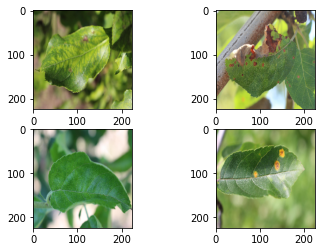

In [11]:
for i in range(4):
	pyplot.subplot(220 + 1 + i)
	pyplot.imshow(train_images[i])
pyplot.show()

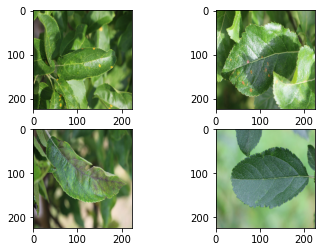

In [12]:
for i in range(4):
	pyplot.subplot(220 + 1 + i)
	pyplot.imshow(test_images[i])
pyplot.show()

In [13]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
x_res, y_res = ros.fit_resample(np.reshape(train_images, (-1, size * size * 3)), targets.to_numpy())
x_res = x_res.reshape((-1, size, size, 3))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [14]:
print(x_res.shape)
print(y_res.shape)

(2488, 224, 224, 3)
(2488, 4)


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2)

In [16]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1990, 224, 224, 3)
(498, 224, 224, 3)
(1990, 4)
(498, 4)


In [0]:
from keras_preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(
    x = x_train, 
    y = y_train
    )

validation_generator = validation_datagen.flow(
    x = x_test,
    y = y_test
    )

In [18]:
def create_model():
  pretrained_model = tf.keras.applications.Xception(input_shape=[*[224, 224], 3], include_top=False)
  pretrained_model.trainable = True
  model = tf.keras.Sequential([
      pretrained_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(4, activation='softmax')
      ])
  
  model.compile(
        loss = 'categorical_crossentropy', 
        optimizer = 'adam', 
        metrics = ['accuracy'])
  return model

model = create_model()

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
83689472/83683744 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


In [0]:
epochs = 12

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 10
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

In [20]:
history = model.fit_generator(
    train_generator, 
    epochs = epochs, 
    validation_data = validation_generator, 
    verbose=1,
    callbacks = [lr_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/12
63/63 [==============================] - 65s 1s/step - loss: 1.3597 - acc: 0.3271 - val_loss: 1.3216 - val_acc: 0.3655

Epoch 00002: LearningRateScheduler reducing learning rate to 1.4000000000000001e-05.
Epoch 2/12
63/63 [==============================] - 44s 705ms/step - loss: 1.2030 - acc: 0.5548 - val_loss: 1.0395 - val_acc: 0.6406

Epoch 00003: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 3/12
63/63 [==============================] - 46s 734ms/step - loss: 0.9043 - acc: 0.7176 - val_loss: 0.7207 - val_acc: 0.7450

Epoch 00004: LearningRateScheduler reducing learning rate to 2.2000000000000003e-05.
Epoch 4/12
63/63 [==============================] - 46s 725ms/step - loss: 0.6060 - acc: 0.8020 - val_loss: 0.5316 - val_acc: 0.8153

Epoch 00005: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 5/12
63/63 [==============================] - 46s 73

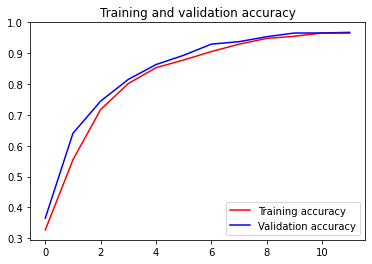

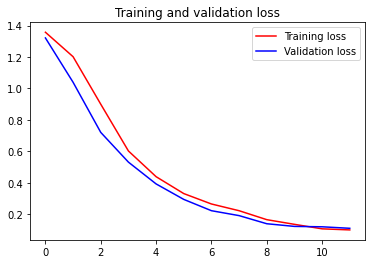

<Figure size 432x288 with 0 Axes>

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [0]:
test_images = np.reshape(test_images, (-1, size, size, 3))

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = train_datagen.flow(
    x = test_images
    )

In [39]:
probabilities = model.predict(test_generator)
print(probabilities)
print(probabilities[:,0].mean())
print(probabilities[:,1].mean())
print(probabilities[:,2].mean())
print(probabilities[:,3].mean())

[[9.7194123e-01 7.9771066e-03 1.3968296e-02 6.1133346e-03]
 [2.7281893e-03 2.3929039e-01 7.5546616e-01 2.5152441e-03]
 [2.8193489e-02 2.3719588e-01 6.2388992e-01 1.1072071e-01]
 ...
 [9.7405771e-03 4.3604267e-01 2.4635436e-03 5.5175316e-01]
 [7.4056507e-04 7.0658402e-04 9.9818915e-01 3.6365376e-04]
 [1.6811293e-03 5.4399157e-03 9.8936099e-01 3.5179406e-03]]
0.21869794
0.106657535
0.37738553
0.297259


In [0]:
test = pd.read_csv('test.csv')
res = pd.DataFrame()
res['image_id'] = test['image_id']
res['healthy'] = probabilities[:, 0]
res['multiple_diseases'] = probabilities[:, 1]
res['rust'] = probabilities[:, 2]
res['scab'] = probabilities[:, 3]

In [0]:
res.to_csv('submission.csv', index=False)